2023-03-17 21:57:49.413202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


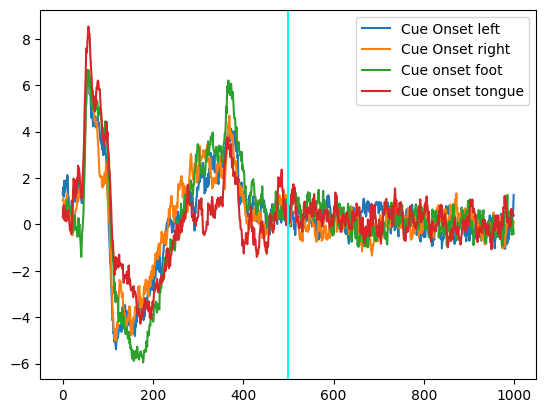

In [1]:
from keras.layers.reshaping.flatten import Flatten
from keras.layers.core.activation import Activation
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import regularizers
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [2]:
def data_prep(X,y,sub_sample,average,noise,period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_reshape = X.reshape(X.shape[0], X.shape[1], -1, sub_sample)
    X_max = np.max(X_reshape, axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    if noise:
      X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y
        
def data_finalize(period, total_number, takeout_sample, y_test=y_test): 
    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)  # get 375 out of 2115 samples and no repetitation
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid)))) # a set(unordered) different with another set, set = set1 - set2

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period=period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period=period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period=period)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return x_train, x_valid, x_test, y_train, y_valid, y_test



X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,noise=True, period=500)


# **Train the model on subject 1 data only and test it on both subject 1 test set and all subject test set**

In [3]:
# get subject 1 data for training and validation set
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

In [4]:
print(X_train_valid.shape)


(237, 22, 1000)


In [5]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [6]:
period_accuracy={}
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)
# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]

model_sub1 = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
model_sub1.summary()

  

model_sub1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
model_sub1_results = model_sub1.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

val_acc = model_sub1_results.history['val_accuracy'][2]
period_accuracy['Sub1'] = val_acc
print(period_accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 250, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 250, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 1, 50)        12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 1, 50)       0

2023-03-17 21:58:14.362670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
25/25 [==============================] - 2s 58ms/step - loss: 1.9807 - accuracy: 0.3667 - val_loss: 5.7457 - val_accuracy: 0.2560
Epoch 2/50
25/25 [==============================] - 1s 49ms/step - loss: 1.2647 - accuracy: 0.5679 - val_loss: 2.3760 - val_accuracy: 0.3929
Epoch 3/50
25/25 [==============================] - 1s 51ms/step - loss: 0.9562 - accuracy: 0.6667 - val_loss: 1.9181 - val_accuracy: 0.3631
Epoch 4/50
25/25 [==============================] - 1s 51ms/step - loss: 0.6669 - accuracy: 0.7705 - val_loss: 1.7414 - val_accuracy: 0.3155
Epoch 5/50
25/25 [==============================] - 1s 50ms/step - loss: 0.5398 - accuracy: 0.8128 - val_loss: 1.9089 - val_accuracy: 0.3631
Epoch 6/50
25/25 [==============================] - 1s 49ms/step - loss: 0.3870 - accuracy: 0.8615 - val_loss: 1.7603 - val_accuracy: 0.3988
Epoch 7/50
25/25 [==============================] - 1s 49ms/step - loss: 0.2788 - accuracy: 0.9013 - val_loss: 1.7163 - val_accuracy: 0.4464
Epoch 8/50
25

In [7]:
cnn_score = model_sub1.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.36000001430511475


In [ ]:
# cnn_score = model_sub1.evaluate(x_test, y_test, verbose=0)
# print('Test accuracy of the basic CNN model:',cnn_score[1])

In [8]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [9]:
period_accuracy={}
for i in range(1000, 1100, 100):
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)

    model_all_subs = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation=tf.nn.gelu, input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'), 
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation=tf.nn.gelu),
      keras.layers.MaxPooling2D(pool_size=(2,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation

  ])

  # Printing the model summary
    model_all_subs.summary()

  

    model_all_subs.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_all_subs_results = model_all_subs.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

    val_acc = model_all_subs_results.history['val_accuracy'][1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 250, 1, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 250, 1, 25)       100       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 250, 1, 25)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 250, 1, 50)        12550     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 1, 50)      

218/218 [==============================] - 12s 57ms/step - loss: 0.2164 - accuracy: 0.9138 - val_loss: 1.4709 - val_accuracy: 0.6253
Epoch 40/50
218/218 [==============================] - 12s 56ms/step - loss: 0.1985 - accuracy: 0.9272 - val_loss: 1.4464 - val_accuracy: 0.6367
Epoch 41/50
218/218 [==============================] - 12s 56ms/step - loss: 0.2106 - accuracy: 0.9220 - val_loss: 1.4333 - val_accuracy: 0.6333
Epoch 42/50
218/218 [==============================] - 12s 57ms/step - loss: 0.1852 - accuracy: 0.9295 - val_loss: 1.4612 - val_accuracy: 0.6447
Epoch 43/50
218/218 [==============================] - 12s 55ms/step - loss: 0.1997 - accuracy: 0.9246 - val_loss: 1.4712 - val_accuracy: 0.6347
Epoch 44/50
218/218 [==============================] - 12s 54ms/step - loss: 0.1953 - accuracy: 0.9319 - val_loss: 1.5512 - val_accuracy: 0.6220
Epoch 45/50
218/218 [==============================] - 12s 56ms/step - loss: 0.1826 - accuracy: 0.9333 - val_loss: 1.5315 - val_accuracy: 0.62

In [10]:
cnn_score = model_all_subs.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of model_all_subs on subject 1 data:',cnn_score[1])
# print(X_test_sub1.shape)
# print(y_test_sub1.shape)

Test accuracy of the basic CNN model: 0.5


In [11]:
print(x_test.shape)
print(y_test.shape)
cnn_score = model_all_subs.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of model_all_subs on all data:',cnn_score[1])

(1772, 500, 1, 22)
(1772, 4)
Test accuracy of the basic CNN model: 0.6077877879142761


In [12]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [13]:
short_time_train_scores = {}
short_time_test_scores = {}
for i in range(50, 450, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 25, 1, 26)         5174      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 1, 26)         0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 9, 1, 26)         104       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 9, 1, 26)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 1, 52)          12220     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 1, 52)        

218/218 [==============================] - 1s 6ms/step - loss: 1.2551 - accuracy: 0.5056 - val_loss: 1.3888 - val_accuracy: 0.4353
Epoch 36/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2515 - accuracy: 0.5045 - val_loss: 1.3945 - val_accuracy: 0.4253
Epoch 37/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2533 - accuracy: 0.5072 - val_loss: 1.4027 - val_accuracy: 0.4353
Epoch 38/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2442 - accuracy: 0.5111 - val_loss: 1.3939 - val_accuracy: 0.4267
Epoch 39/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2397 - accuracy: 0.5109 - val_loss: 1.4010 - val_accuracy: 0.4193
Epoch 40/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2525 - accuracy: 0.5073 - val_loss: 1.4177 - val_accuracy: 0.4247
Epoch 41/50
218/218 [==============================] - 1s 6ms/step - loss: 1.2350 - accuracy: 0.5247 - val_loss: 1.4236 - val_accuracy: 0.4453
Epoch 42/50

Epoch 18/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2591 - accuracy: 0.5494 - val_loss: 1.3262 - val_accuracy: 0.4940
Epoch 19/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2450 - accuracy: 0.5585 - val_loss: 1.3483 - val_accuracy: 0.4893
Epoch 20/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2403 - accuracy: 0.5602 - val_loss: 1.3684 - val_accuracy: 0.5053
Epoch 21/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2364 - accuracy: 0.5644 - val_loss: 1.3224 - val_accuracy: 0.5093
Epoch 22/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2311 - accuracy: 0.5668 - val_loss: 1.3956 - val_accuracy: 0.4867
Epoch 23/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2151 - accuracy: 0.5776 - val_loss: 1.3329 - val_accuracy: 0.5080
Epoch 24/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2104 - accuracy: 0.5790 - val_loss: 1.3440 - val_accuracy: 0.4960

Epoch 1/50
218/218 [==============================] - 4s 12ms/step - loss: 2.0462 - accuracy: 0.2922 - val_loss: 1.7912 - val_accuracy: 0.3033
Epoch 2/50
218/218 [==============================] - 2s 11ms/step - loss: 1.7830 - accuracy: 0.3249 - val_loss: 1.7038 - val_accuracy: 0.3380
Epoch 3/50
218/218 [==============================] - 2s 11ms/step - loss: 1.7005 - accuracy: 0.3486 - val_loss: 1.6581 - val_accuracy: 0.3687
Epoch 4/50
218/218 [==============================] - 2s 11ms/step - loss: 1.6382 - accuracy: 0.3672 - val_loss: 1.5972 - val_accuracy: 0.3713
Epoch 5/50
218/218 [==============================] - 2s 11ms/step - loss: 1.5813 - accuracy: 0.3934 - val_loss: 1.5572 - val_accuracy: 0.3693
Epoch 6/50
218/218 [==============================] - 2s 11ms/step - loss: 1.5247 - accuracy: 0.4239 - val_loss: 1.5078 - val_accuracy: 0.4153
Epoch 7/50
218/218 [==============================] - 2s 11ms/step - loss: 1.4869 - accuracy: 0.4376 - val_loss: 1.4938 - val_accuracy: 0.3873

 conv2d_19 (Conv2D)          (None, 34, 1, 52)         12220     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 12, 1, 52)        0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 12, 1, 52)        208       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 12, 1, 52)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 1, 104)        48776     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 4, 1, 104)        0         
 g2D)                                                            
                                                                 
 batch_nor

Epoch 41/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0247 - accuracy: 0.7424 - val_loss: 1.3101 - val_accuracy: 0.6287
Epoch 42/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0432 - accuracy: 0.7343 - val_loss: 1.3207 - val_accuracy: 0.6340
Epoch 43/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0254 - accuracy: 0.7434 - val_loss: 1.3426 - val_accuracy: 0.6073
Epoch 44/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0168 - accuracy: 0.7468 - val_loss: 1.3352 - val_accuracy: 0.6307
Epoch 45/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0267 - accuracy: 0.7378 - val_loss: 1.3513 - val_accuracy: 0.6173
Epoch 46/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0352 - accuracy: 0.7361 - val_loss: 1.3392 - val_accuracy: 0.6293
Epoch 47/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0261 - accuracy: 0.7392 - val_loss: 1.2893 - val_accuracy:

218/218 [==============================] - 3s 16ms/step - loss: 1.0634 - accuracy: 0.7198 - val_loss: 1.3124 - val_accuracy: 0.6287
Epoch 24/50
218/218 [==============================] - 3s 16ms/step - loss: 1.0348 - accuracy: 0.7389 - val_loss: 1.3223 - val_accuracy: 0.6173
Epoch 25/50
218/218 [==============================] - 3s 16ms/step - loss: 1.0260 - accuracy: 0.7356 - val_loss: 1.2631 - val_accuracy: 0.6467
Epoch 26/50
218/218 [==============================] - 3s 16ms/step - loss: 1.0340 - accuracy: 0.7392 - val_loss: 1.2438 - val_accuracy: 0.6467
Epoch 27/50
218/218 [==============================] - 3s 15ms/step - loss: 1.0167 - accuracy: 0.7447 - val_loss: 1.2499 - val_accuracy: 0.6540
Epoch 28/50
218/218 [==============================] - 3s 16ms/step - loss: 1.0267 - accuracy: 0.7476 - val_loss: 1.2796 - val_accuracy: 0.6553
Epoch 29/50
218/218 [==============================] - 3s 15ms/step - loss: 1.0344 - accuracy: 0.7398 - val_loss: 1.2659 - val_accuracy: 0.6500
Epoc

218/218 [==============================] - 4s 19ms/step - loss: 1.5296 - accuracy: 0.4924 - val_loss: 1.5759 - val_accuracy: 0.4427
Epoch 6/50
218/218 [==============================] - 4s 18ms/step - loss: 1.4350 - accuracy: 0.5310 - val_loss: 1.4592 - val_accuracy: 0.5087
Epoch 7/50
218/218 [==============================] - 4s 18ms/step - loss: 1.3561 - accuracy: 0.5684 - val_loss: 1.4158 - val_accuracy: 0.5013
Epoch 8/50
218/218 [==============================] - 4s 19ms/step - loss: 1.2943 - accuracy: 0.5928 - val_loss: 1.3834 - val_accuracy: 0.5407
Epoch 9/50
218/218 [==============================] - 4s 20ms/step - loss: 1.2523 - accuracy: 0.6121 - val_loss: 1.3543 - val_accuracy: 0.5433
Epoch 10/50
218/218 [==============================] - 4s 20ms/step - loss: 1.2375 - accuracy: 0.6208 - val_loss: 1.3182 - val_accuracy: 0.5673
Epoch 11/50
218/218 [==============================] - 4s 20ms/step - loss: 1.1795 - accuracy: 0.6499 - val_loss: 1.3042 - val_accuracy: 0.5827
Epoch 12

                                                                 
 conv2d_32 (Conv2D)          (None, 20, 1, 104)        48776     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 7, 1, 104)        0         
 g2D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 7, 1, 104)        416       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 7, 1, 104)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 7, 1, 208)         194896    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 3, 1, 208)        0         
 g2D)                                                            
          

218/218 [==============================] - 4s 20ms/step - loss: 0.8970 - accuracy: 0.8254 - val_loss: 1.2800 - val_accuracy: 0.6900
Epoch 46/50
218/218 [==============================] - 4s 20ms/step - loss: 0.9202 - accuracy: 0.8119 - val_loss: 1.3589 - val_accuracy: 0.6587
Epoch 47/50
218/218 [==============================] - 4s 20ms/step - loss: 0.9248 - accuracy: 0.8162 - val_loss: 1.3397 - val_accuracy: 0.6660
Epoch 48/50
218/218 [==============================] - 5s 21ms/step - loss: 0.9119 - accuracy: 0.8193 - val_loss: 1.3231 - val_accuracy: 0.6967
Epoch 49/50
218/218 [==============================] - 5s 21ms/step - loss: 0.9353 - accuracy: 0.8168 - val_loss: 1.3595 - val_accuracy: 0.6833
Epoch 50/50
56/56 [==============================] - 0s 6ms/step - loss: 1.2630 - accuracy: 0.6953
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 200

Epoch 28/50
218/218 [==============================] - 5s 22ms/step - loss: 0.9505 - accuracy: 0.7925 - val_loss: 1.2288 - val_accuracy: 0.6693
Epoch 29/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9260 - accuracy: 0.7993 - val_loss: 1.2586 - val_accuracy: 0.6760
Epoch 30/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9338 - accuracy: 0.8016 - val_loss: 1.2386 - val_accuracy: 0.6733
Epoch 31/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9203 - accuracy: 0.8079 - val_loss: 1.2247 - val_accuracy: 0.7020
Epoch 32/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9268 - accuracy: 0.8039 - val_loss: 1.2608 - val_accuracy: 0.6840
Epoch 33/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9102 - accuracy: 0.8109 - val_loss: 1.3415 - val_accuracy: 0.6487
Epoch 34/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9038 - accuracy: 0.8188 - val_loss: 1.2434 - val_accuracy:

In [14]:
for i in range(450, 550, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 225, 1, 26)        5174      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 75, 1, 26)        0         
 g2D)                                                            
                                                                 
 batch_normalization_38 (Bat  (None, 75, 1, 26)        104       
 chNormalization)                                                
                                                                 
 dropout_38 (Dropout)        (None, 75, 1, 26)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 75, 1, 52)         12220     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 25, 1, 52)      

Epoch 35/50
218/218 [==============================] - 6s 27ms/step - loss: 0.8863 - accuracy: 0.8263 - val_loss: 1.2032 - val_accuracy: 0.6980
Epoch 36/50
218/218 [==============================] - 6s 26ms/step - loss: 0.8869 - accuracy: 0.8339 - val_loss: 1.1802 - val_accuracy: 0.6993
Epoch 37/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8978 - accuracy: 0.8272 - val_loss: 1.1644 - val_accuracy: 0.7067
Epoch 38/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8742 - accuracy: 0.8313 - val_loss: 1.1412 - val_accuracy: 0.7393
Epoch 39/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8733 - accuracy: 0.8346 - val_loss: 1.1282 - val_accuracy: 0.7413
Epoch 40/50
218/218 [==============================] - 5s 25ms/step - loss: 0.8805 - accuracy: 0.8371 - val_loss: 1.1854 - val_accuracy: 0.7127
Epoch 41/50
218/218 [==============================] - 5s 24ms/step - loss: 0.8860 - accuracy: 0.8307 - val_loss: 1.1430 - val_accuracy:

218/218 [==============================] - 6s 29ms/step - loss: 0.9923 - accuracy: 0.7638 - val_loss: 1.2422 - val_accuracy: 0.6600
Epoch 18/50
218/218 [==============================] - 6s 28ms/step - loss: 0.9758 - accuracy: 0.7727 - val_loss: 1.2791 - val_accuracy: 0.6760
Epoch 19/50
218/218 [==============================] - 6s 29ms/step - loss: 0.9644 - accuracy: 0.7787 - val_loss: 1.2952 - val_accuracy: 0.6567
Epoch 20/50
218/218 [==============================] - 6s 28ms/step - loss: 0.9677 - accuracy: 0.7767 - val_loss: 1.2477 - val_accuracy: 0.6607
Epoch 21/50
218/218 [==============================] - 6s 28ms/step - loss: 0.9438 - accuracy: 0.7911 - val_loss: 1.2608 - val_accuracy: 0.6700
Epoch 22/50
218/218 [==============================] - 6s 28ms/step - loss: 0.9226 - accuracy: 0.8017 - val_loss: 1.2748 - val_accuracy: 0.6633
Epoch 23/50
218/218 [==============================] - 6s 28ms/step - loss: 0.9361 - accuracy: 0.7970 - val_loss: 1.3286 - val_accuracy: 0.6560
Epoc

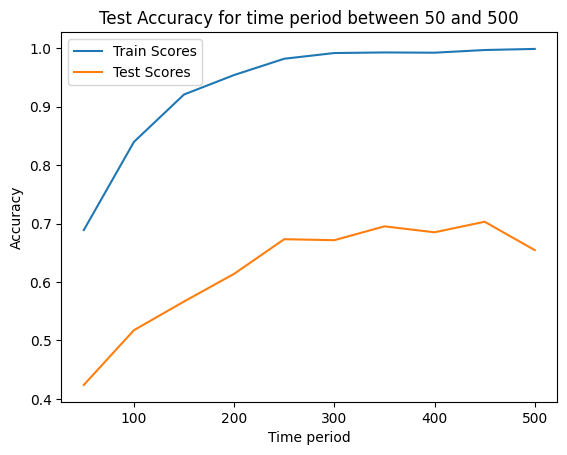

In [17]:
import matplotlib.pyplot as plt

# Create lists for x and y values
x_values = [int(k) for k in short_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in short_time_train_scores.values()]
test_scores = [v for v in short_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 50 and 500')
plt.legend()

# Show the plot
plt.show()

In [16]:
long_time_train_scores = {}
long_time_test_scores = {}
for i in range(600, 1100, 100):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

  # Printing the model summary
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_results = model.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

    long_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    long_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(long_time_train_scores)
print(long_time_test_scores)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 300, 1, 26)        5174      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 100, 1, 26)       0         
 g2D)                                                            
                                                                 
 batch_normalization_50 (Bat  (None, 100, 1, 26)       104       
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 100, 1, 26)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 100, 1, 52)        12220     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 34, 1, 52)      

Epoch 35/50
218/218 [==============================] - 7s 31ms/step - loss: 0.8644 - accuracy: 0.8432 - val_loss: 1.3106 - val_accuracy: 0.6520
Epoch 36/50
218/218 [==============================] - 7s 32ms/step - loss: 0.8705 - accuracy: 0.8455 - val_loss: 1.2415 - val_accuracy: 0.7013
Epoch 37/50
218/218 [==============================] - 7s 31ms/step - loss: 0.8854 - accuracy: 0.8391 - val_loss: 1.2983 - val_accuracy: 0.6673
Epoch 38/50
218/218 [==============================] - 7s 31ms/step - loss: 0.8637 - accuracy: 0.8463 - val_loss: 1.2596 - val_accuracy: 0.6913
Epoch 39/50
218/218 [==============================] - 7s 30ms/step - loss: 0.8681 - accuracy: 0.8438 - val_loss: 1.2931 - val_accuracy: 0.6753
Epoch 40/50
218/218 [==============================] - 6s 30ms/step - loss: 0.8544 - accuracy: 0.8503 - val_loss: 1.2822 - val_accuracy: 0.6953
Epoch 41/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8604 - accuracy: 0.8460 - val_loss: 1.3344 - val_accuracy:

218/218 [==============================] - 7s 34ms/step - loss: 1.0174 - accuracy: 0.7659 - val_loss: 1.3821 - val_accuracy: 0.6400
Epoch 18/50
218/218 [==============================] - 7s 34ms/step - loss: 0.9898 - accuracy: 0.7776 - val_loss: 1.3661 - val_accuracy: 0.6447
Epoch 19/50
218/218 [==============================] - 8s 34ms/step - loss: 0.9786 - accuracy: 0.7836 - val_loss: 1.3935 - val_accuracy: 0.6227
Epoch 20/50
218/218 [==============================] - 7s 34ms/step - loss: 0.9462 - accuracy: 0.8006 - val_loss: 1.4205 - val_accuracy: 0.6367
Epoch 21/50
218/218 [==============================] - 7s 33ms/step - loss: 0.9509 - accuracy: 0.7990 - val_loss: 1.4182 - val_accuracy: 0.6280
Epoch 22/50
218/218 [==============================] - 7s 34ms/step - loss: 0.9319 - accuracy: 0.8111 - val_loss: 1.4222 - val_accuracy: 0.6367
Epoch 23/50
218/218 [==============================] - 8s 35ms/step - loss: 0.9389 - accuracy: 0.8069 - val_loss: 1.4113 - val_accuracy: 0.6487
Epoc

Total params: 266,790
Trainable params: 266,010
Non-trainable params: 780
_________________________________________________________________
Epoch 1/50
218/218 [==============================] - 9s 34ms/step - loss: 2.5298 - accuracy: 0.3282 - val_loss: 2.0404 - val_accuracy: 0.3707
Epoch 2/50
218/218 [==============================] - 8s 37ms/step - loss: 2.0524 - accuracy: 0.4060 - val_loss: 1.9137 - val_accuracy: 0.3893
Epoch 3/50
218/218 [==============================] - 9s 40ms/step - loss: 1.8445 - accuracy: 0.4649 - val_loss: 1.7435 - val_accuracy: 0.4800
Epoch 4/50
218/218 [==============================] - 9s 40ms/step - loss: 1.6742 - accuracy: 0.5132 - val_loss: 1.6512 - val_accuracy: 0.4673
Epoch 5/50
218/218 [==============================] - 9s 41ms/step - loss: 1.5308 - accuracy: 0.5674 - val_loss: 1.5833 - val_accuracy: 0.5380
Epoch 6/50
218/218 [==============================] - 9s 41ms/step - loss: 1.4579 - accuracy: 0.5963 - val_loss: 1.5017 - val_accuracy: 0.5447
Ep

                                                                 
 dropout_62 (Dropout)        (None, 150, 1, 26)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 150, 1, 52)        12220     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 50, 1, 52)        0         
 g2D)                                                            
                                                                 
 batch_normalization_63 (Bat  (None, 50, 1, 52)        208       
 chNormalization)                                                
                                                                 
 dropout_63 (Dropout)        (None, 50, 1, 52)         0         
                                                                 
 conv2d_64 (Conv2D)          (None, 50, 1, 104)        48776     
                                                                 
 max_pooli

218/218 [==============================] - 9s 42ms/step - loss: 0.8594 - accuracy: 0.8550 - val_loss: 1.5352 - val_accuracy: 0.6367
Epoch 40/50
218/218 [==============================] - 9s 42ms/step - loss: 0.8696 - accuracy: 0.8621 - val_loss: 1.5502 - val_accuracy: 0.6560
Epoch 41/50
218/218 [==============================] - 10s 44ms/step - loss: 0.8638 - accuracy: 0.8614 - val_loss: 1.4493 - val_accuracy: 0.6687
Epoch 42/50
218/218 [==============================] - 9s 42ms/step - loss: 0.8860 - accuracy: 0.8540 - val_loss: 1.4949 - val_accuracy: 0.6567
Epoch 43/50
218/218 [==============================] - 9s 41ms/step - loss: 0.8621 - accuracy: 0.8618 - val_loss: 1.4753 - val_accuracy: 0.6840
Epoch 44/50
218/218 [==============================] - 9s 41ms/step - loss: 0.8780 - accuracy: 0.8576 - val_loss: 1.5151 - val_accuracy: 0.6780
Epoch 45/50
218/218 [==============================] - 9s 43ms/step - loss: 0.8508 - accuracy: 0.8716 - val_loss: 1.5051 - val_accuracy: 0.6807
Epo

218/218 [==============================] - 10s 48ms/step - loss: 0.9552 - accuracy: 0.8142 - val_loss: 1.4999 - val_accuracy: 0.6360
Epoch 22/50
218/218 [==============================] - 11s 51ms/step - loss: 0.9515 - accuracy: 0.8231 - val_loss: 1.5355 - val_accuracy: 0.6280
Epoch 23/50
218/218 [==============================] - 12s 53ms/step - loss: 0.9300 - accuracy: 0.8250 - val_loss: 1.4892 - val_accuracy: 0.6527
Epoch 24/50
218/218 [==============================] - 11s 49ms/step - loss: 0.9399 - accuracy: 0.8251 - val_loss: 1.5235 - val_accuracy: 0.6293
Epoch 25/50
218/218 [==============================] - 10s 48ms/step - loss: 0.9154 - accuracy: 0.8369 - val_loss: 1.4698 - val_accuracy: 0.6493
Epoch 26/50
218/218 [==============================] - 10s 47ms/step - loss: 0.9162 - accuracy: 0.8346 - val_loss: 1.5096 - val_accuracy: 0.6480
Epoch 27/50
218/218 [==============================] - 10s 48ms/step - loss: 0.9245 - accuracy: 0.8336 - val_loss: 1.4922 - val_accuracy: 0.64

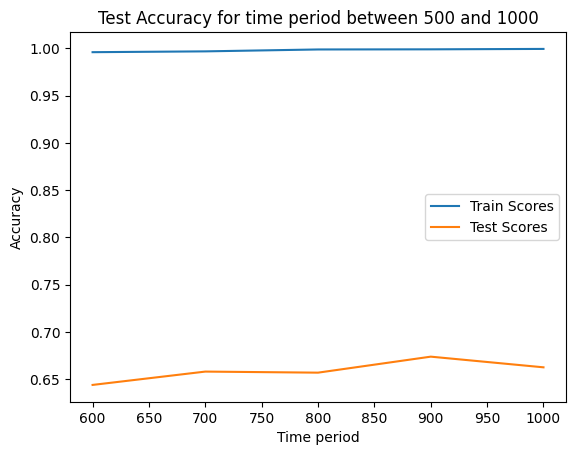

In [18]:
# Create lists for x and y values
x_values = [int(k) for k in long_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in long_time_train_scores.values()]
test_scores = [v for v in long_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 500 and 1000')
plt.legend()

# Show the plot
plt.show()